# Import

In [1]:
import sys

root_dir = '../../'
if root_dir not in sys.path:
    sys.path.append(root_dir)

import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import pandas as pd

pd.set_option('display.max_columns', 100)

from modules import losses, models, samplers, searches, regularizers, evaluators, trainers, datasets, distributions

# Dataset

In [2]:
dataset = datasets.ML20m()
n_user = dataset.n_user
n_item = dataset.n_item
train_set, test_set = dataset.get_train_and_test_set(neg_pair_weight=30)

# device setting
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_set = torch.LongTensor(train_set).to(device)
test_set = torch.FloatTensor(test_set).to(device)

# Evaluator

In [3]:
# k
ks = [5, 10, 50]

score_function_dict = {
    # "Recall"      : evaluators.recall,
    # "Unpopularity": evaluators.unpopularity,
    # "Unpopularity2": evaluators.unpopularity2,
    # "Unpopularity3": evaluators.unpopularity3,
    # "F1-score"    : evaluators.f1_score,
    # "F1-score2"    : evaluators.f1_score2,
    # "F1-score3"    : evaluators.f1_score3,
    "my_metric1"   : evaluators.my_metric1,
    "my_metric2"   : evaluators.my_metric2
}
userwise = evaluators.UserwiseEvaluator(test_set, score_function_dict, ks)
# coverage = evaluators.CoverageEvaluator(test_set, ks)
# hubness = evaluators.HubnessEvaluator(test_set, ks)

# Sampler

In [4]:
sampler = samplers.BaseSampler(train_set, n_user, n_item, device=device, strict_negative=False)

# Model

In [5]:
# Hyperparameters
lr = 1e-3
n_dim = 30
n_batch = 256
n_epoch = 50
no_progressbar = True

model = models.CollaborativeMetricLearning(n_user, n_item, n_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = losses.SumTripletLoss(margin=1).to(device)
trainer = trainers.BaseTrainer(model, optimizer, criterion, sampler, no_progressbar)

# No Training Result

In [6]:
knn = searches.NearestNeighborhood(model)
trainer.valid(knn, userwise)
re_no_training = trainer.valid_scores.copy()
display(re_no_training)

,my_metric1@5,my_metric2@5,my_metric1@10,my_metric2@10,my_metric1@50,my_metric2@50
0,0.789038,0.012864,0.808109,0.012951,0.812695,0.01274


# Training

In [7]:
# only traing no validation
trainer.fit(n_batch, n_epoch)

# Result

## Base CML

In [8]:
knn = searches.NearestNeighborhood(model)

# Recall
trainer.valid(knn, userwise)
re_base = trainer.valid_scores.copy()
display(re_base)

,my_metric1@5,my_metric2@5,my_metric1@10,my_metric2@10,my_metric1@50,my_metric2@50
0,1.059051,0.114839,1.029584,0.099999,0.954141,0.073724


## CML+MP

In [9]:
n_item_sample = 600
n_user_sample = 600
bias_li = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
gamma = distributions.Gamma()

In [10]:
re_mpcml_li = []
for bias in bias_li:
    print(f'bias={bias}')
    mp = searches.MutualProximity(model, gamma, n_item_sample, n_user_sample, bias)
    trainer.valid(mp, userwise)
    re = trainer.valid_scores.copy()
    display(re)
    re_mpcml_li.append(re)

bias=0.0


,my_metric1@5,my_metric2@5,my_metric1@10,my_metric2@10,my_metric1@50,my_metric2@50
0,0.94047,0.025367,0.972901,0.027825,0.96361,0.031164


bias=0.1


,my_metric1@5,my_metric2@5,my_metric1@10,my_metric2@10,my_metric1@50,my_metric2@50
0,1.0286,0.032116,1.058684,0.033774,0.995889,0.035369


bias=0.2


,my_metric1@5,my_metric2@5,my_metric1@10,my_metric2@10,my_metric1@50,my_metric2@50
0,1.061698,0.036355,1.049509,0.03824,1.000768,0.039035


bias=0.3


,my_metric1@5,my_metric2@5,my_metric1@10,my_metric2@10,my_metric1@50,my_metric2@50
0,1.066723,0.040457,1.082249,0.042445,1.022414,0.042631


bias=0.4


,my_metric1@5,my_metric2@5,my_metric1@10,my_metric2@10,my_metric1@50,my_metric2@50
0,1.094082,0.044284,1.089123,0.046624,1.035843,0.046437


bias=0.5


,my_metric1@5,my_metric2@5,my_metric1@10,my_metric2@10,my_metric1@50,my_metric2@50
0,1.110687,0.048688,1.120514,0.051605,1.04884,0.050552


bias=0.6


,my_metric1@5,my_metric2@5,my_metric1@10,my_metric2@10,my_metric1@50,my_metric2@50
0,1.117273,0.053614,1.136438,0.057318,1.057688,0.055067


bias=0.7


,my_metric1@5,my_metric2@5,my_metric1@10,my_metric2@10,my_metric1@50,my_metric2@50
0,1.130022,0.059971,1.160789,0.06448,1.065809,0.060058


bias=0.8


,my_metric1@5,my_metric2@5,my_metric1@10,my_metric2@10,my_metric1@50,my_metric2@50
0,1.165112,0.069358,1.189275,0.074282,1.064477,0.065349


bias=0.9


,my_metric1@5,my_metric2@5,my_metric1@10,my_metric2@10,my_metric1@50,my_metric2@50
0,1.207191,0.08521,1.202,0.089642,1.031391,0.070441


bias=1.0


,my_metric1@5,my_metric2@5,my_metric1@10,my_metric2@10,my_metric1@50,my_metric2@50
0,1.058824,0.11478,1.029477,0.099971,0.954129,0.073723


In [11]:
re_1 = []
re_2 = []
for re in re_mpcml_li:
    re_1.append(re.iloc[-1, 2])
    re_2.append(re.iloc[-1, 3])

In [12]:
re_base_1 = []
re_base_2 = []
for _ in range(len(bias_li)):
    re_base_1.append(re_base.iloc[-1, 2])
    re_base_2.append(re_base.iloc[-1, 3])

## my_metric1

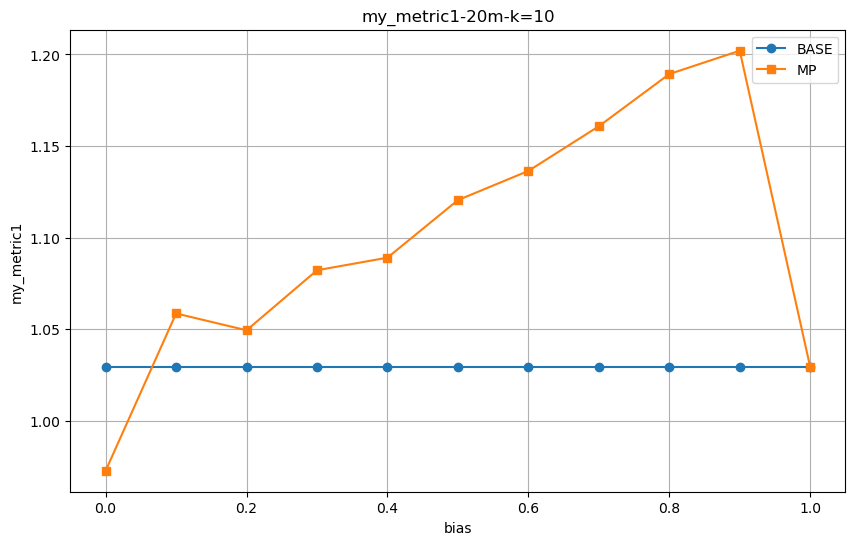

In [15]:
# グラフの作成
plt.figure(figsize=(10, 6))
plt.plot(bias_li, re_base_1, label='BASE', marker='o')
plt.plot(bias_li, re_1, label='MP', marker='s')

# タイトルとラベルの追加
plt.title('my_metric1-20m-k=10')
plt.xlabel('bias')
plt.ylabel('my_metric1')
plt.legend()

# グリッドを表示
plt.grid(True)

# グラフの表示
plt.show()

## me_metric2

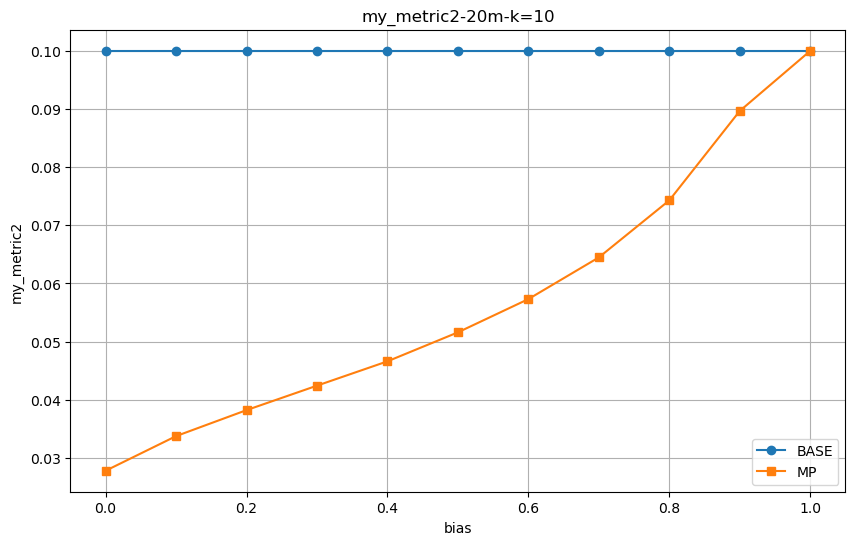

In [16]:
# グラフの作成
plt.figure(figsize=(10, 6))
plt.plot(bias_li, re_base_2, label='BASE', marker='o')
plt.plot(bias_li, re_2, label='MP', marker='s')

# タイトルとラベルの追加
plt.title('my_metric2-20m-k=10')
plt.xlabel('bias')
plt.ylabel('my_metric2')
plt.legend()

# グリッドを表示
plt.grid(True)

# グラフの表示
plt.show()